In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [2]:
#===========================================================
# File Name : B_DA_RETL_CHURN MODEL                           
# Description :                                             
# Date : 2020-11-12                                         
# Writer : Yoon Jun Beom
# Packages :                                                
# Note :                           
#===========================================================

# Data Preprocessing

In [3]:
# library import 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import make_scorer
import seaborn as sns

import joblib

In [4]:
# 가맹점 별 운영정보 데이터
base = pd.read_csv(r".\b_da_retl_churn_anl_md_tmp_table.csv")
base.drop("레코드 수", axis= 1, inplace = True)

base = base[['reg_no','amt_day_cnt', 'avg_amt', 'avg_cnt', 'avg_mm_amt', 'avg_mm_cnt',
           'bf_month_diff_amt', 'bf_month_diff_cnt', 'high_lw_term',
           'join_term', 'last_xmit_date', 'm3_sd_amt', 'm3_sd_cnt', 'm_00_app_amt',
           'm_00_app_cnt', 'm_01_app_amt', 'm_01_app_cnt', 'm_02_app_amt',
           'm_02_app_cnt', 'm_03_app_amt', 'm_03_app_cnt', 'm_04_app_amt',
           'm_04_app_cnt', 'm_05_app_amt', 'm_05_app_cnt', 'max_amt_month',
           'min_amt_month', 'min_mm_amt', 'min_mm_cnt', 'min_xmit_date',
           'month_cnt', 'mx_mm_amt', 'mx_mm_cnt', 'mx_xmit_date', 
           'sd_amt', 'sd_mm_amt', 'sd_mm_cnt', 'sum_amt', 'sum_cnt',
           'wk2_amt_diff', 'wk2_cnt_diff', 'churn_yn']]

In [5]:
# 가맹점코드 매핑, 분류 조정
map_code_info = pd.read_csv(r".\b_svr_map_code_info.csv")
map_code_info.drop(['레코드 수', 'load_dtm'], axis = 1, inplace = True)

li = [ 
["부페", "중식", "퓨전/기타음식점", "한식-일반음식점", "양식", "일식/수산물", "분식/휴게음식점", "패스트푸드/제과점"]	, "음식점" ,
["실내스포츠시설운영업", "실외스포츠시설운영업", "스포츠시설운영업"]	, "스포츠시설운영업",
["예체능계학원", "외국어학원", "일반교과학원", "기타학원", "학습지/코칭교육"]	, "학원",
["자동차및부품판매점", "자동차정비/세차/주차장"]	, "자동차관련판매점",
["유흥주점-무도/가무", "일반유흥주점"]	, "주점",
["독서실/도서관"]	, "기타시설운영업",
["세탁/가사/전문서비스", "주택수리서비스", "용품수리서비스"]	, "대행/용역/인력알선",
["약국/한약방", "유사의료업", "의료관련서비스업"]	, "병원",
["예식/의례/관혼상제"]	, "수의업"
]    
a = []  
b = []

for i in li:
    if type(i) == list :
        a.append(i)
    else :
        b.append(i)
        
for i, j in zip(a, b):
    map_code_info['cd_lv2_nm'].replace(i, j, inplace= True)        

In [6]:
# 가맹점 정보 매핑
debit_retl = pd.read_csv(r".\debit_retl.csv", dtype='str')

In [7]:
debit_retl = debit_retl[['reg_no','h_code','dbr_new_svr_code']]
map_code_info = map_code_info[['map_cd','map_gubun','cd_lv2_nm']]
debit_retl = debit_retl.merge(map_code_info.query("map_gubun == 'V'"), 'left', left_on= 'dbr_new_svr_code', right_on = 'map_cd')

In [8]:
new = debit_retl.merge(map_code_info.query("map_gubun == 'V'"), 'left', left_on= 'dbr_new_svr_code', right_on = 'map_cd')

In [10]:
month_tot = base.copy()

In [11]:
month_tot['reg_no'] = month_tot.reg_no.astype("str")

In [12]:
# Feature engineering (비중)
for i in range(6):
    month_tot[f'm{str(i+1)}_cnt_rto'] = month_tot[f'm_{str(i).zfill(2)}_app_cnt'] / month_tot['sum_cnt'] 
    month_tot[f'm{str(i+1)}_amt_rto'] = month_tot[f'm_{str(i).zfill(2)}_app_amt'] / month_tot['sum_amt'] 

# MoM (전월 대비 증감율)
for i in range(5):        
    month_tot[f'm{str(i).zfill(2)}_cnt_updn_rto'] = (month_tot[f'm_{str(i).zfill(2)}_app_cnt'] / month_tot[f'm_{str(i+1).zfill(2)}_app_cnt']) -1 
    month_tot[f'm{str(i).zfill(2)}_amt_updn_rto'] = (month_tot[f'm_{str(i).zfill(2)}_app_amt'] / month_tot[f'm_{str(i+1).zfill(2)}_app_amt']) -1 

In [13]:
month_tot.replace([np.inf, -np.inf], np.nan, inplace = True)

In [14]:
for col in month_tot.columns : # [month_tot.columns.str.contains(r"(_rto)")]
    if month_tot[col].dtype == 'object': 
        pass 
    month_tot.fillna({col:0}, inplace = True)

month_tot['avg_cnt_updn_rto'] = month_tot[month_tot.columns[month_tot.columns.str.contains(r"(_cnt_updn_rto)")]].mean(1)
month_tot['avg_amt_updn_rto'] = month_tot[month_tot.columns[month_tot.columns.str.contains(r"(_amt_updn_rto)")]].mean(1)

base_tot = month_tot.merge(debit_retl[['reg_no','cd_lv2_nm']], 'inner', on = 'reg_no')

base_tot = base_tot[base_tot.cd_lv2_nm.notna()]

In [15]:
# 운영했던 일자 수
base_tot['norm_wrk_day'] = \
pd.to_datetime(base_tot.mx_xmit_date, format = "%Y%m%d") - pd.to_datetime(base_tot.min_xmit_date, format = "%Y%m%d") + np.timedelta64(1, 'D')
base_tot['norm_wrk_day'] = base_tot.norm_wrk_day / np.timedelta64(1, 'D')

In [16]:
# 매출일 수 / 운영일 수
base_tot['amt_day_rto'] = base_tot.amt_day_cnt / base_tot.norm_wrk_day

In [17]:
reg_churn_model = base_tot.drop(["mx_xmit_date", "last_xmit_date","min_xmit_date", "norm_wrk_day", "amt_day_cnt",
                      "min_mm_amt", "mx_mm_amt", "max_amt_month", "min_amt_month", "mx_mm_cnt", "min_mm_cnt"], axis = 1)

# Build Model

In [19]:
reg_churn_model['churn_yn'] = reg_churn_model.churn_yn.factorize()[0]
reg_churn_model['cd_lv2_nm'] = reg_churn_model.cd_lv2_nm.factorize()[0]

y = reg_churn_model['churn_yn'].values
X = reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [23]:
m = round(np.sqrt(len(reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).columns)),0)

In [20]:
rf = RandomForestClassifier(n_estimators=100, max_features= "sqrt", random_state=1)

In [21]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [22]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'.format(accuracy_score(y_test, y_pred.round())))

Model accuracy score with 10 decision-trees : 0.9583


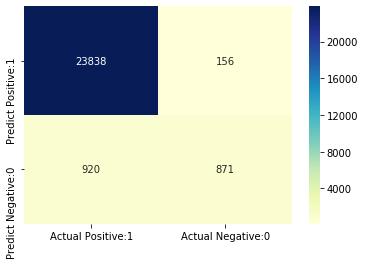

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred.round())
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# K-fold test (k = 3)
##### stratified k-fold cross-validation (shuffle)

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
skf = StratifiedShuffleSplit(n_splits=3)

In [ ]:
rf = RandomForestClassifier(n_estimators=50, random_state=1)

In [ ]:
for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)
    y_pred = (y_prob[:,1] >= 0.35).astype("int")
    print(f"______________{idx}______________") 
    print(f"accuracy_score : {accuracy_score(y_test, y_pred):0.4f}")
    print(f"f1_score : {f1_score(y_test, y_pred):0.4f}")
    print(f"precision_score : {precision_score(y_test, y_pred):0.4f}")
    print(f"recall_score : {recall_score(y_test, y_pred):0.4f}")
    print(f"_______________________________") 

# Parameter Select 
#### GridSearch

In [30]:
scoring = {'Accuracy': make_scorer(accuracy_score),
            'Precision': 'precision',
            'Recall': make_scorer(recall_score),
            'F1_score': make_scorer(f1_score),
            }

In [41]:
param_grid = {
    'max_depth': [i for i in range(6,15)], 
    'n_estimators': [100], #[10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [42]:
estimator = RandomForestClassifier()

In [66]:
skf = StratifiedShuffleSplit(n_splits=5)

In [67]:
grid_search = GridSearchCV(estimator = estimator, 
                           param_grid = param_grid, 
                           cv = skf,
                           scoring = scoring,
                           refit='F1_score',
                           n_jobs = -1)

# fit with (x_train, y_train)
grid_search.fit(X, y)
print(f"best_parameter : {grid_search.best_params_}")

best_parameter : {'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 100}


In [68]:
result = pd.DataFrame(grid_search.cv_results_['params'])
result['mean_test_Accuracy'] = grid_search.cv_results_['mean_test_Accuracy']
result['mean_test_F1_score'] = grid_search.cv_results_['mean_test_F1_score']

In [69]:
result.sort_values(by='mean_test_Accuracy', ascending=False).head()

,max_depth,max_features,n_estimators,mean_test_Accuracy,mean_test_F1_score
22,13,sqrt,100,0.959884,0.620748
25,14,sqrt,100,0.959791,0.622894
24,14,auto,100,0.959395,0.619328
21,13,auto,100,0.959302,0.616143
19,12,sqrt,100,0.958604,0.605786


In [70]:
result.sort_values(by='mean_test_F1_score', ascending=False).head()

,max_depth,max_features,n_estimators,mean_test_Accuracy,mean_test_F1_score
25,14,sqrt,100,0.959791,0.622894
22,13,sqrt,100,0.959884,0.620748
24,14,auto,100,0.959395,0.619328
21,13,auto,100,0.959302,0.616143
19,12,sqrt,100,0.958604,0.605786


In [53]:
best_model = grid_search.best_estimator_

# best model 
#### Select Cutoff (0.35)

In [71]:
rf = RandomForestClassifier(n_estimators=100, max_features= "sqrt", max_depth= 14, random_state=1)

In [74]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, max_features='sqrt', random_state=1)

In [78]:
# find cut off
y_prob = rf.predict_proba(X_test)
i = 0.3
data = []
while True : 
    if i > 0.9 :
        break
    y_pred = (y_prob[:,1] >= i).astype("int")
    data.append([i,accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])
    i = i + 0.01

In [79]:
result = pd.DataFrame(data)
result.columns = ['cutoff','accuracy', 'precision','recall', 'f1_score', 'roc_auc_score']
result # 0.35 

,cutoff,accuracy,precision,recall,f1_score,roc_auc_score
0,0.30,0.950320,0.609756,0.732759,0.665623,0.849411
1,0.31,0.951367,0.620178,0.720690,0.666667,0.844375
2,0.32,0.952763,0.635514,0.703448,0.667758,0.837127
3,0.33,0.953345,0.643200,0.693103,0.667220,0.832640
4,0.34,0.954043,0.654424,0.675862,0.664970,0.825018
5,0.35,0.955323,0.668966,0.668966,0.668966,0.822505
6,0.36,0.955439,0.676840,0.650000,0.663149,0.813771
7,0.37,0.955207,0.680222,0.634483,0.656557,0.806449
8,0.38,0.955323,0.687023,0.620690,0.652174,0.800114
9,0.39,0.956021,0.702811,0.603448,0.649351,0.792491


In [77]:
for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)
    y_pred = (y_prob[:,1] >= 0.45).astype("int")
    print(f"______________{idx}______________") 
    print(f"accuracy_score : {accuracy_score(y_test, y_pred):0.4f}")
    print(f"f1_score : {f1_score(y_test, y_pred):0.4f}")
    print(f"precision_score : {precision_score(y_test, y_pred):0.4f}")
    print(f"recall_score : {recall_score(y_test, y_pred):0.4f}")
    print(f"_______________________________") 

______________0______________
accuracy_score : 0.9601
f1_score : 0.6607
precision_score : 0.7749
recall_score : 0.5759
_______________________________
______________1______________
accuracy_score : 0.9597
f1_score : 0.6601
precision_score : 0.7671
recall_score : 0.5793
_______________________________
______________2______________
accuracy_score : 0.9596
f1_score : 0.6477
precision_score : 0.7877
recall_score : 0.5500
_______________________________
______________3______________
accuracy_score : 0.9615
f1_score : 0.6706
precision_score : 0.7929
recall_score : 0.5810
_______________________________
______________4______________
accuracy_score : 0.9581
f1_score : 0.6296
precision_score : 0.7806
recall_score : 0.5276
_______________________________


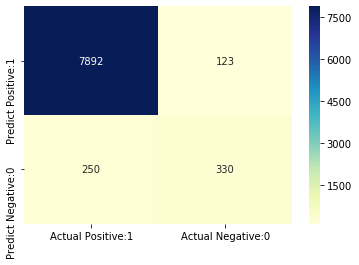

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Feature importance

In [54]:
best_model.feature_importances_

array([0.01086783, 0.00847556, 0.01046377, 0.011688  , 0.0931823 ,
       0.08184549, 0.01008077, 0.02552663, 0.01186322, 0.00984152,
       0.01247473, 0.00978481, 0.00995739, 0.00924214, 0.00698327,
       0.0069016 , 0.00708088, 0.00660063, 0.0062404 , 0.00625925,
       0.01022127, 0.00796331, 0.00530657, 0.01289335, 0.01015066,
       0.01263418, 0.01007421, 0.01202195, 0.11904669, 0.10029352,
       0.0434319 , 0.03199049, 0.01338061, 0.01131462, 0.00875792,
       0.00807541, 0.00808832, 0.00744974, 0.00885878, 0.00824995,
       0.01415653, 0.0174096 , 0.0383835 , 0.02179583, 0.00780283,
       0.00839635, 0.00638919, 0.00621342, 0.00502535, 0.00559373,
       0.00483083, 0.00445906, 0.01350676, 0.01628456, 0.00879047,
       0.01539835])

In [55]:
feature_scores = pd.Series(best_model.feature_importances_, index=reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).columns).sort_values(ascending=False)

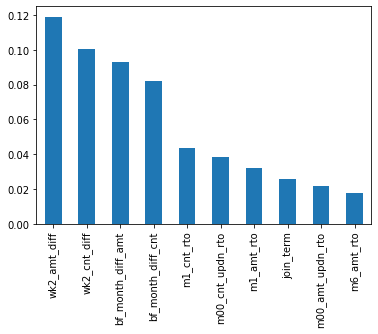

In [56]:
# 최근 2주간의 amt, cmt '변화' 
# 전월 대비 amt, cnt 변화
# 그 밖에 6개월 sum cnt 중에서 차지하는 비율 등 바로 직전 기간의 가맹점 실적이 중요한 변수로 보여짐
feature_scores[:10].plot(kind = 'bar')

# Save Model

In [ ]:
best_model = rf.fit(X)

In [ ]:
joblib.dump(best_model, 'churn_model.pkl')